In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd
%cd /content/drive/MyDrive/ALBEF-main/models
!pwd

/content
/content/drive/MyDrive/ALBEF-main/models
/content/drive/MyDrive/ALBEF-main/models


In [3]:
'''
 * Copyright (c) 2021, salesforce.com, inc.
 * All rights reserved.
 * SPDX-License-Identifier: BSD-3-Clause
 * For full license text, see LICENSE.txt file in the repo root or https://opensource.org/licenses/BSD-3-Clause
'''
!pip install timm
!pip install transformers==4.8.1
from functools import partial
from vit import VisionTransformer, interpolate_pos_embed
from xbert import BertConfig, BertForMaskedLM

import torch
import torch.nn.functional as F
from torch import nn

import numpy as np
import random
############
import yaml
import json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 26.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 38.7 MB/s 
     |████████████████████████████████| 3.3 MB 64.8 MB/s 
     |████████████████████████████████| 880 kB 87.3 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=5f2d5ca44fdfcda43b2978890c9df01d88b1d11bf5dcbfb9f642049b6c7f4d0a
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [4]:
!pwd

/content/drive/MyDrive/ALBEF-main/models


In [5]:
embed_dim = 256


vision_width = 768
image_res = 256
visual_encoder = VisionTransformer(
    img_size=image_res, patch_size=16, embed_dim=768, depth=12, num_heads=12, 
    mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))
vision_proj = nn.Linear(vision_width, embed_dim) # (vision_width, embed_dim)


embed_dim = 256
# print(config['bert_config'])
text_width = 768
bert_config = BertConfig.from_json_file('../configs/config_bert.json')
text_encoder = BertForMaskedLM.from_pretrained('bert-base-uncased', config=bert_config)
text_proj = nn.Linear(text_width, embed_dim) # (text_width, embed_dim)

# create momentum models
visual_encoder_m = VisionTransformer(
    img_size=image_res, patch_size=16, embed_dim=768, depth=12, num_heads=12, 
    mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))
vision_proj_m = nn.Linear(vision_width, embed_dim)
text_encoder_m = BertForMaskedLM.from_pretrained('bert-base-uncased', config=bert_config)       
text_proj_m = nn.Linear(text_width, embed_dim)    

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

# ALBEF 모델  
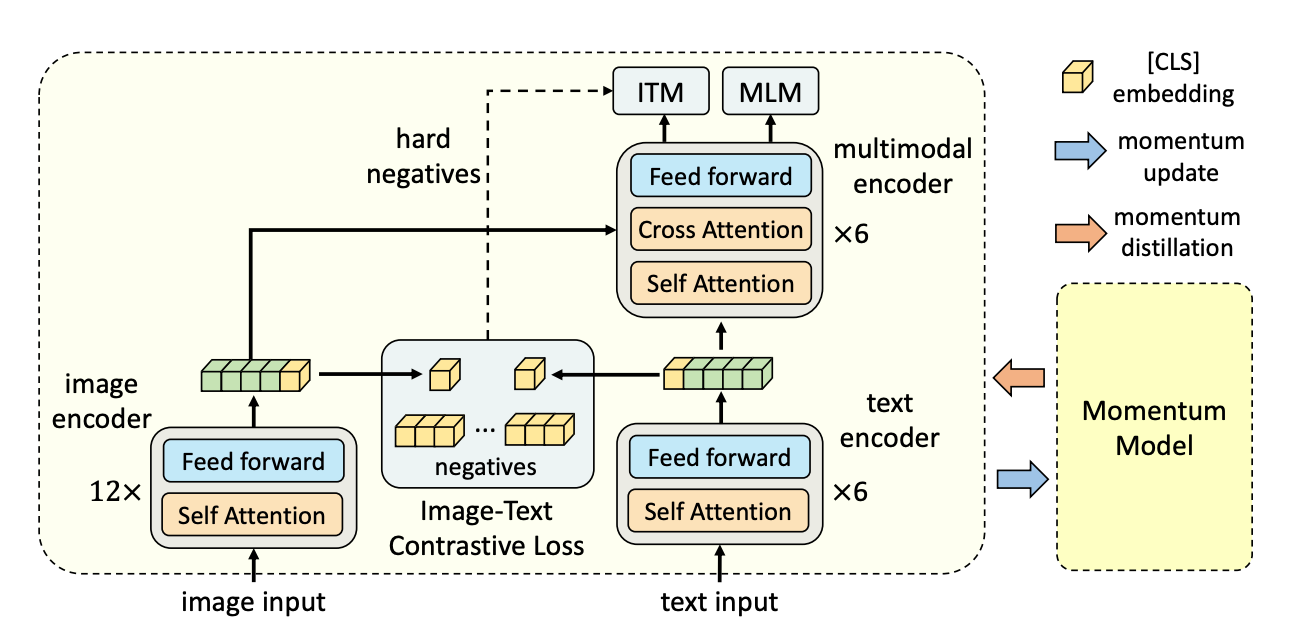

# Image encoder
## Image
코드 분석을 위하여 각각의 캡션을 가지고 있는 이미지 3개를 사용 할 것임

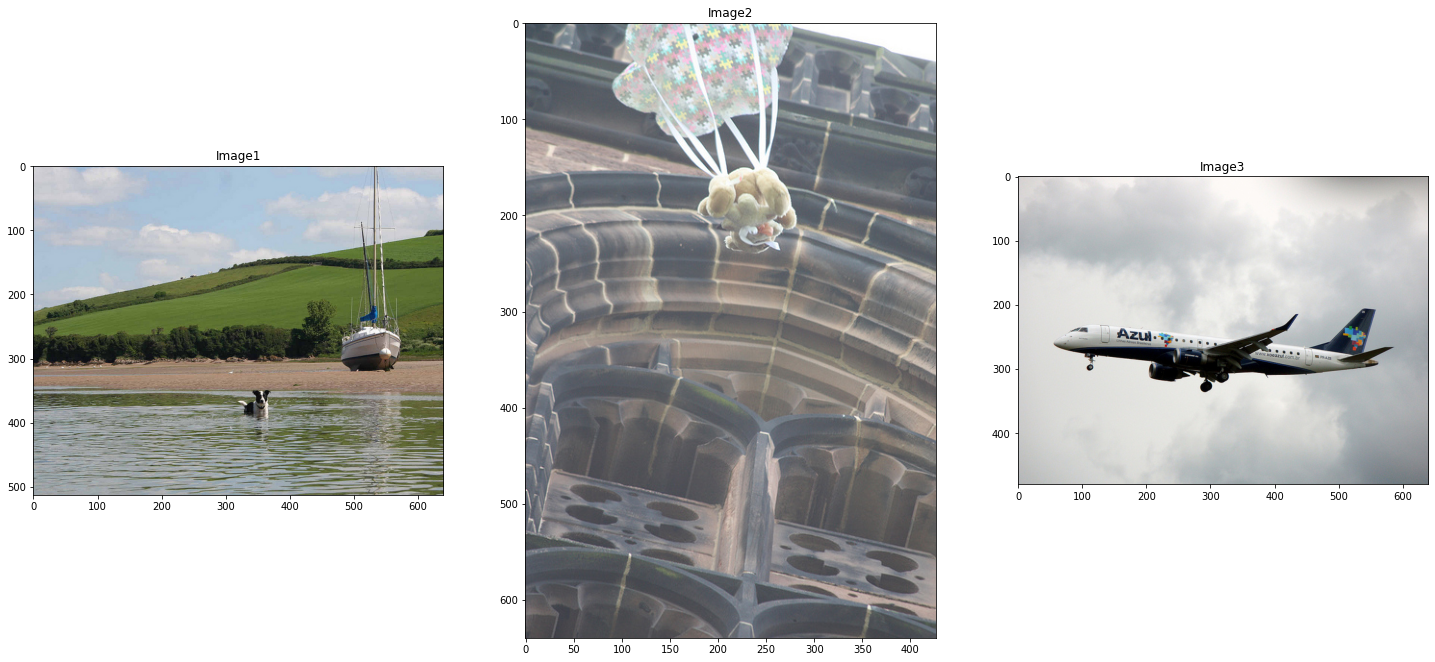

In [6]:
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
import os
# !rm -r ./data/.ipynb_checkpoints

img_dir = "/content/drive/MyDrive/ALBEF-main/models/data"
img_list = os.listdir(img_dir)
rows = 1
columns = len(img_list)

fig, axs = plt.subplots(2, 2, figsize=(25, 25))

for i in range(len(img_list)):
    image_index = i + 1
    ttitle = f"Image{image_index}" # image title
    plt.subplot(rows, columns, image_index) # subplot
    plt.title(ttitle)   # title
    plt.imshow(plt.imread(os.path.join(img_dir, img_list[i])))
plt.show()

ViT모델의 input size는 (256, 256)으로 설정하였음.  
따라서 이미지를 resize해준 후, 이미지를 하나의 배치로 생각하고 차원을 추가해줌

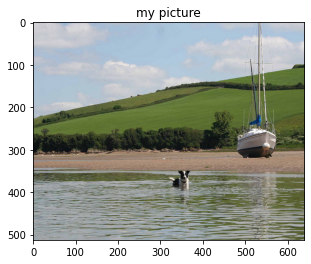

(513, 640, 3)


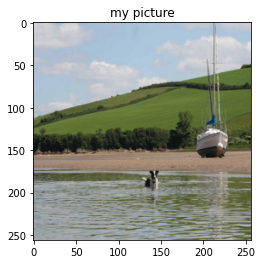

torch.Size([3, 256, 256])
torch.Size([1, 3, 256, 256])


In [7]:
image_one = "./data/caption_image1.jpg"
plt.imshow(plt.imread(image_one))
plt.title('my picture')
plt.show()
print(plt.imread(image_one).shape)

image_one = Image.open(image_one)
transform = Compose([Resize((256, 256))])
image_one = transform(image_one)
plt.imshow(image_one)
plt.title('my picture')
plt.show()


transform = Compose([ToTensor()])
image_one = transform(image_one)
print(image_one.shape)

image_one = image_one.unsqueeze(0)
print(image_one.shape)

3개의 그림에 적용해보자

In [8]:
Image_list = []
transform = Compose([Resize((256, 256)), ToTensor()])
for i in range(len(img_list)):
    image = Image.open(os.path.join(img_dir, img_list[i]))
    image = transform(image)
    image = image.unsqueeze(0)
    Image_list.append(image)

image_input = torch.concat(Image_list, dim = 0)
print(image_input.shape)

torch.Size([3, 3, 256, 256])


위의 image_input은 ViT 모델의 input으로 사용 됨  

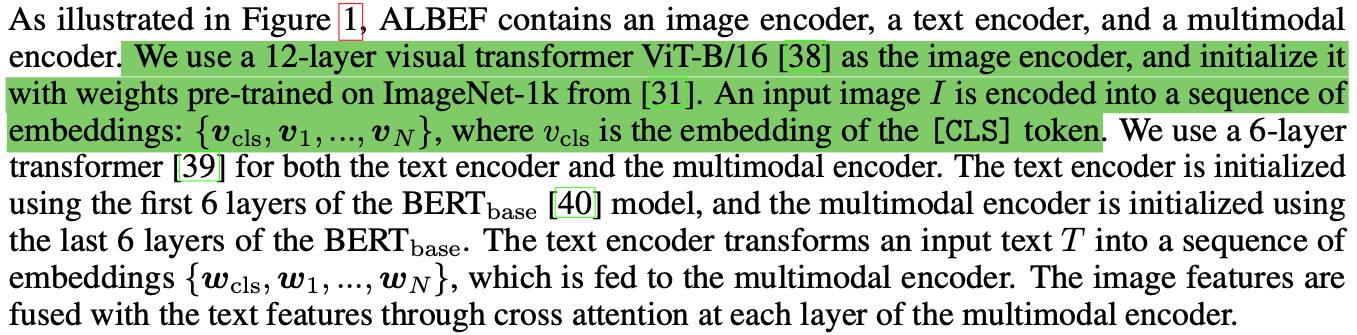

- ViT 모델와 projection layer 초기화

In [9]:
embed_dim = 256
vision_width = 768
image_res = 256
visual_encoder = VisionTransformer(
    img_size=image_res, patch_size=16, embed_dim=768, depth=12, num_heads=12, 
    mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))

vision_proj = nn.Linear(vision_width, embed_dim) # [768, 256]


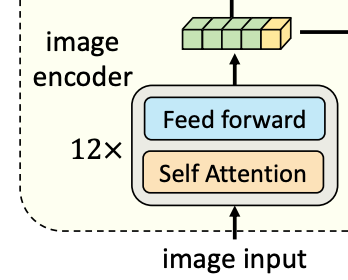

입력 이미지 $I$를 일렬의 임베딩$\{\overrightarrow{v_{cls}},\overrightarrow{v_{1}},...,\overrightarrow{v_{N}}\}$으로 인코딩 하는데,  
출력 차원을 보면 256→257로 $\overrightarrow{v_{cls}}$ 토큰이 하나 추가된 걸 알 수 있음

In [10]:
image_embeds = visual_encoder(image_input)
print("image_embeds: ", image_embeds.shape)
print(image_embeds[:,0,:].shape)
image_feat = F.normalize(vision_proj(image_embeds[:,0,:]),dim=-1)
print("image_feat: ", image_feat.shape)


image_atts = torch.ones(image_embeds.size()[:-1],dtype=torch.long).to(image.device)
print("image_atts: ", image_atts.shape) # 추후 Bert의 attention mask에 사용

image_embeds:  torch.Size([3, 257, 768])
torch.Size([3, 768])
image_feat:  torch.Size([3, 256])
image_atts:  torch.Size([3, 257])


# Text encoder

다음은 Text encoder의 모델과 text input 값을 알아보겠음

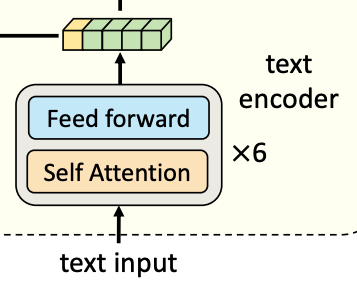

논문에서 text encoder는 BERTbase 모델의 first 6-layer를 사용해 초기화 하였고, 입력 텍스트 $T$를 일렬의 임베딩 $\{\overrightarrow{w_{cls}},\overrightarrow{w_{1}},...,\overrightarrow{w_{N}}\}$으로 변환하여 multimodal encoder에 들어감

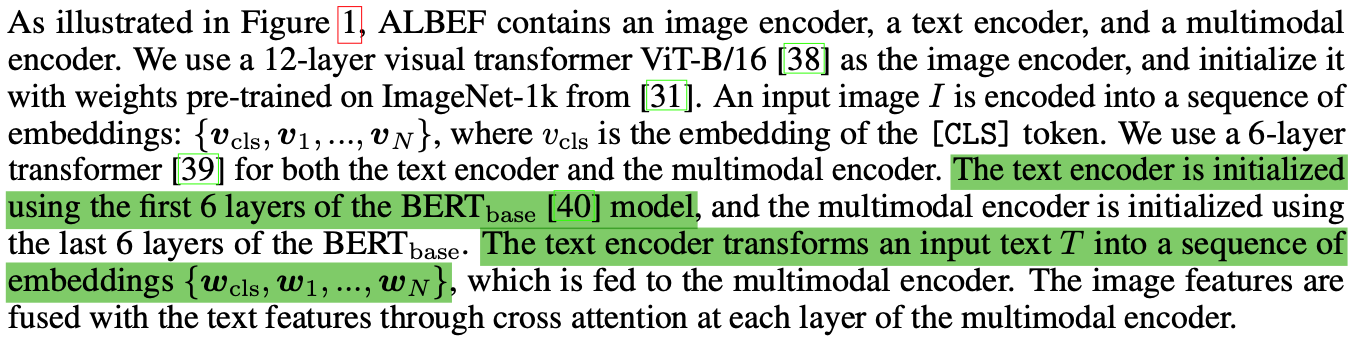

In [11]:
embed_dim = 256
text_width = 768
bert_config = BertConfig.from_json_file('../configs/config_bert.json')
text_encoder = BertForMaskedLM.from_pretrained('bert-base-uncased', config=bert_config)
text_proj = nn.Linear(text_width, embed_dim) # (text_width, embed_dim)

MLM 모델을 사용함  

첫번째 개 사진의 caption임   
"The dog is swimming in the lake on a sunny day"

In [12]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
text = tokenizer("The dog is swimming in the lake on a sunny day") 
print("text:", text)


Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

text: {'input_ids': [101, 1109, 3676, 1110, 5947, 1107, 1103, 3521, 1113, 170, 21162, 1285, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


[cls]토큰이 하나 추가되었고, token_type_ids, attention_mask을 볼 수 있음  
[pad]같은 special token이 없으니 attention_mask는 모두 1  
input_ids의 어느 부분이 첫 번째 문장이고 어느 것이 두 번째 문장인지 모델에 알려줌. 단일 문장이니 없음~

In [13]:
text.input_ids = torch.Tensor(text.input_ids).to(torch.long)
text.input_ids = text.input_ids.unsqueeze(dim=0)
print("text.input_id:", text.input_ids.shape)

text.attention_mask = torch.Tensor(text.attention_mask)
text.attention_mask = text.attention_mask.unsqueeze(dim=0)
print("text.attention_mask:", text.attention_mask.shape)

text_output = text_encoder.bert(torch.Tensor(text.input_ids), attention_mask = torch.Tensor(text.attention_mask),                      
                                return_dict = True, mode = 'text')     

text_embeds = text_output.last_hidden_state
print("text_embeds", text_embeds.shape)
text_feat = F.normalize(text_proj(text_embeds[:,0,:]),dim=-1)     
print("text_feat", text_feat.shape)

text.input_id: torch.Size([1, 13])
text.attention_mask: torch.Size([1, 13])
text_embeds torch.Size([1, 13, 768])
text_feat torch.Size([1, 256])


input_id와 attention_mask를 bert모델에 넣어주면  
입력 텍스트 $T$가 일렬의 임베딩 $\{\overrightarrow{w_{cls}},\overrightarrow{w_{1}},...,\overrightarrow{w_{N}}\}$으로 변환됨  
이 중 $\overrightarrow{w_{cls}}$만 활용할거기 때문에 $\overrightarrow{w_{cls}}$만 선형층을 projection해줌    
     

       
이제 이미지에 맞게 captoin 3개로 똑같이 진행

In [14]:
# image_atts = torch.ones(image_embeds.size()[:-1],dtype=torch.long).to(image.device)
print("image_atts: ", image_atts.shape) # 추후 Bert의 attention mask에 사용
text1 = "The dog is swimming in the lake on a sunny day"
text2 = "a stuffed animal with a parachute falling from above"
text3 = "A larger commerical jet is flying in the air"

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
text = tokenizer([text1, text2, text3], padding=True)

text.input_ids = torch.Tensor(text.input_ids).to(torch.long)
text.attention_mask = torch.Tensor(text.attention_mask)

print("text.input_id", text.input_ids.shape)
print("text.attention_mask", text.attention_mask.shape)

text_output = text_encoder.bert(text.input_ids, text.attention_mask,                      
                                return_dict = True, mode = 'text')     

text_embeds = text_output.last_hidden_state
print("text_embeds.shape", text_embeds.shape)
text_feat = F.normalize(text_proj(text_embeds[:,0,:]),dim=-1)                 
print("text_feat", text_feat.shape)

image_atts:  torch.Size([3, 257])
text.input_id torch.Size([3, 13])
text.attention_mask torch.Size([3, 13])
text_embeds.shape torch.Size([3, 13, 768])
text_feat torch.Size([3, 256])


# Momentum Model

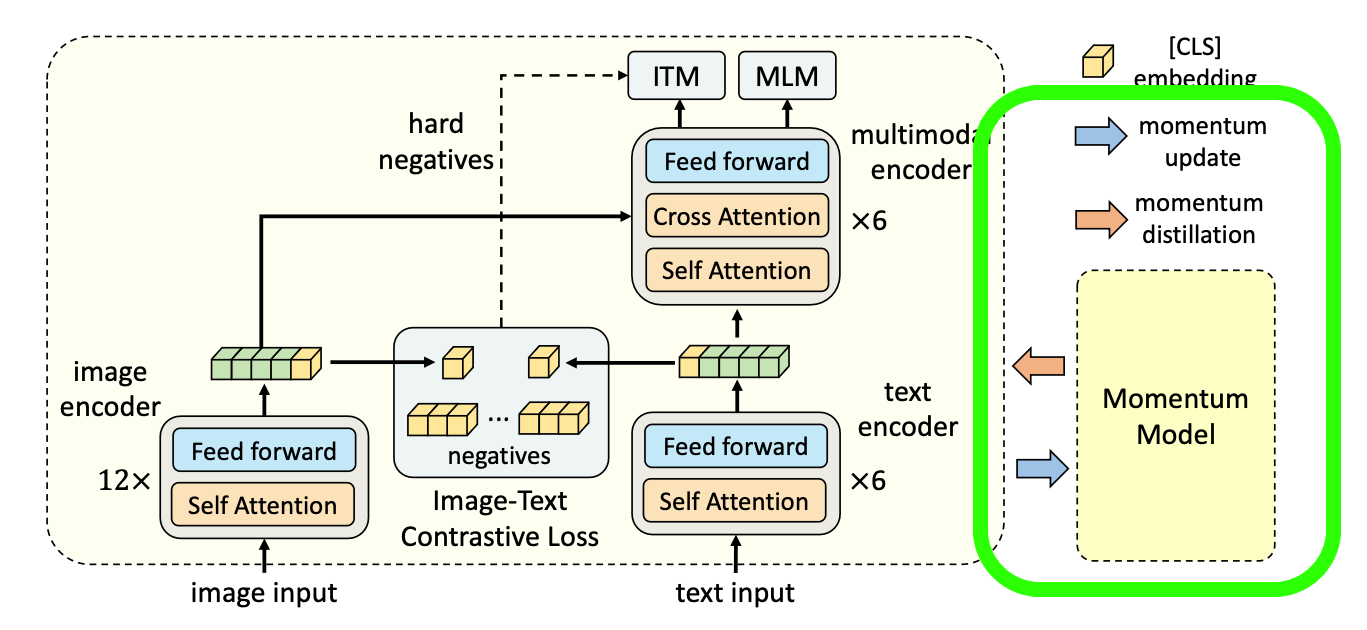

Momentum Distillation(MoD) 모델의 초기화  
text encoder의 모델과 동일 하지만 backpropagation은 수행 X

In [15]:
# create momentum models
visual_encoder_m = VisionTransformer(
    img_size=image_res, patch_size=16, embed_dim=768, depth=12, num_heads=12, 
    mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))
vision_proj_m = nn.Linear(vision_width, embed_dim)
text_encoder_m = BertForMaskedLM.from_pretrained('bert-base-uncased', config=bert_config)       
text_proj_m = nn.Linear(text_width, embed_dim)    

Exponential Moving Average(EMA 확인 - 이론 ppt에 적어놓음). 

$V_t = β×V_{t-1} + (1-β)×Θ_t$  
β 는 0~1 사이의 값을 갖는 하이퍼파라미터, 세타(Θ)는 새로 들어온 데이터, V는 현재의 경향을 나타냄  
momentum model에서는 momendum_update라는 method를 통해 EMA를 진행하는데,  
결국 momentum model은 새로 들어온 데이터에 둔감하게 반응 $→$ 본 논문에 서 말하는 itc의 노이즈에 둔감.


In [16]:
model_pairs =  [[visual_encoder, visual_encoder_m],
                [vision_proj, vision_proj_m],
                [text_encoder, text_encoder_m],
                [text_proj,text_proj_m],
               ]

momentum= 0.995
def momentum_update(model_pairs):
    for model_pair in model_pairs:           
        for param, param_m in zip(model_pair[0].parameters(), model_pair[1].parameters()):
            param_m.data = param_m.data * momentum + param.data * (1. - momentum)

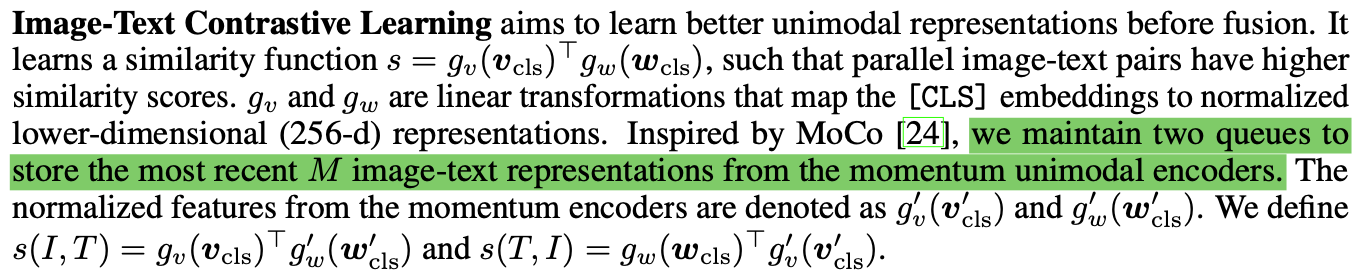

한번의 iteration이 돌때마다 dequeue_and_enqueue method가 실행되느데  
이때 batch_size 만큼의 image-text representaions에 사용되는  
image-feature, text-featrue가 image_queue,text_queue에 각각 저장됨 

코드르 보면 알겠지만 dequeue됨과 동시에 enqueue됨을 알 수 있음
  
concat_all_gather는 병렬 프로세싱을 적용하기 위한 method임  

In [17]:
@torch.no_grad()
def _dequeue_and_enqueue(self, image_feat, text_feat):
    # gather keys before updating queue
    image_feats = concat_all_gather(image_feat)
    text_feats = concat_all_gather(text_feat)

    batch_size = image_feats.shape[0]

    ptr = int(self.queue_ptr)
    assert self.queue_size % batch_size == 0  # for simplicity

    # replace the keys at ptr (dequeue and enqueue)
    self.image_queue[:, ptr:ptr + batch_size] = image_feats.T
    self.text_queue[:, ptr:ptr + batch_size] = text_feats.T
    ptr = (ptr + batch_size) % self.queue_size  # move pointer

    self.queue_ptr[0] = ptr 


@torch.no_grad()
def concat_all_gather(tensor):
    """
    Performs all_gather operation on the provided tensors.
    *** Warning ***: torch.distributed.all_gather has no gradient.
    """
    tensors_gather = [torch.ones_like(tensor)
        for _ in range(torch.distributed.get_world_size())]
    torch.distributed.all_gather(tensors_gather, tensor, async_op=False)

    output = torch.cat(tensors_gather, dim=0)
    return output

원본 코드에서는 아래와 같에 register_buffer로 queue로 선언 하였는데  
nn.register_buffer("image_queue", torch.randn(randn, queue_size))  
nn.register_buffer("text_queue", torch.randn(embed_dim, queue_size))    
nn.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))  

register_buffer의 기능은 아래와 같음
1. optimizer가 업데이트하지 않는다.
2. 그러나 값은 존재한다(하나의 layer로써 작용한다고 보면 된다.)
3. state_dict()로 확인이 가능하다.
4. GPU연산이 가능하다.  

따라서 네트워크를 구성함에 있어서 네트워크를 end2end로 학습시키고 싶은데 중간에 업데이트를 하지않는 일반 layer를 넣고 싶을 때 사용할 수 있다.

본 코드에서는 편의상 torch.randn으로 queue를 구현하였음


In [18]:
queue_size = 65536
randn = 256
embed_dim = 256

image_queue = torch.randn(randn, queue_size)
text_queue = torch.randn(embed_dim, queue_size)
image_queue = nn.functional.normalize(image_queue, dim=0)
text_queue = nn.functional.normalize(text_queue, dim=0)
print('image_queue, text_queue:', image_queue.shape, text_queue.shape) # [256, 65536]

image_queue, text_queue: torch.Size([256, 65536]) torch.Size([256, 65536])


# ITC  
임베딩된 [cls]토큰을 이용해서 ITC 계산

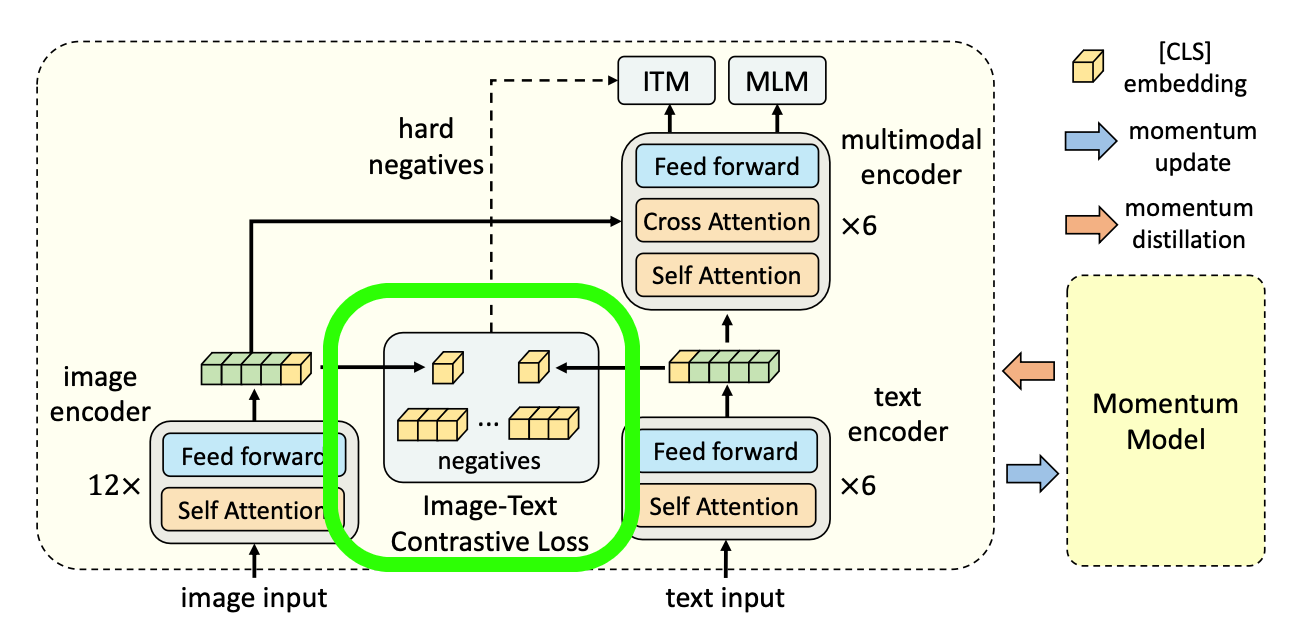

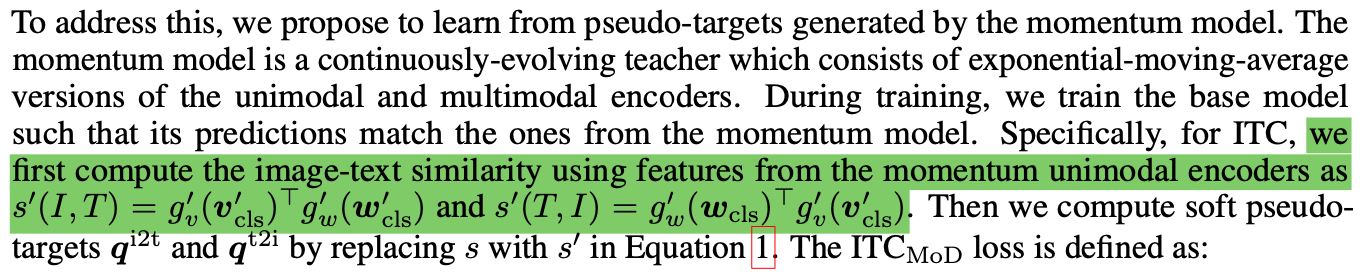

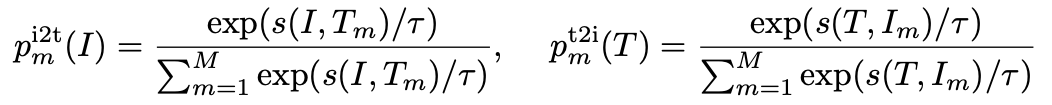

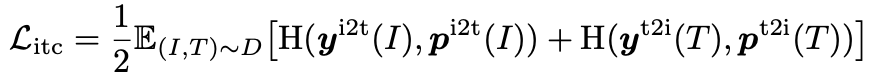

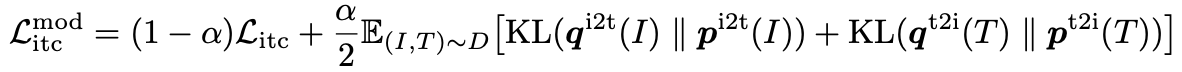

In [19]:
def print_size(image_embeds_m, image_feat_m, image_feat_all, text_output_m, text_feat_m, text_feat_all, sim_i2t_m, sim_t2i_m, sim_targets, sim_i2t_targets, sim_t2i_targets):
    print("image_embeds_m:", image_embeds_m)
    print("image_feat_m:", image_feat_m)
    print("image_feat_all:", image_feat_all)
    print("text_output_m:", text_output_m)
    print("text_feat_m:", text_feat_m)
    print("text_feat_all:", text_feat_all)
    print("sim_i2t_m:", sim_i2t_m)
    print("sim_t2i_m:", sim_t2i_m)
    print("sim_targets:", sim_targets.shape)
    print(sim_targets)
    print("sim_i2t_targets:", sim_i2t_targets)
    print("sim_t2i_targets:", sim_t2i_targets)
        


In [20]:
temp = 0.07
alpha = 0.4

# get momentum features
with torch.no_grad():
    momentum_update(model_pairs)
    image_embeds_m = visual_encoder_m(image_input)  # [3, 257, 768]
    image_feat_m = F.normalize(vision_proj_m(image_embeds_m[:,0,:]),dim=-1) # [3, 256]
    image_feat_all = torch.cat([image_feat_m.t(), image_queue.clone().detach()],dim=1) # cat([256, 3], [256, 65536])=[256, 65539]


    text_output_m = text_encoder_m.bert(text.input_ids, attention_mask = text.attention_mask,                 
                                        return_dict = True, mode = 'text')  # [3, 13, 768]   

    text_feat_m = F.normalize(text_proj_m(text_output_m.last_hidden_state[:,0,:]),dim=-1) # [3, 256]
    text_feat_all = torch.cat([text_feat_m.t(), text_queue.clone().detach()],dim=1) # [256, 65539]

    sim_i2t_m = image_feat_m @ text_feat_all / temp # [3, 256] @ [256, 65539] = [3, 65539]
    sim_t2i_m = text_feat_m @ image_feat_all / temp # [3, 65539]

    sim_targets = torch.zeros(sim_i2t_m.size()).to(image.device) # [3, 65539]
    sim_targets.fill_diagonal_(1)

    sim_i2t_targets = alpha * F.softmax(sim_i2t_m, dim=1) + (1 - alpha) * sim_targets # [3, 65539]
    sim_t2i_targets = alpha * F.softmax(sim_t2i_m, dim=1) + (1 - alpha) * sim_targets # [3, 65539]

    print_size(image_embeds_m.shape, image_feat_m.shape, image_feat_all.shape, text_output_m.last_hidden_state.shape, 
               text_feat_m.shape, text_feat_all.shape, sim_i2t_m.shape, sim_t2i_m.shape, 
               sim_targets, sim_i2t_targets.shape, sim_t2i_targets.shape)
################

sim_i2t = image_feat @ text_feat_all / temp # [3, 65539]
sim_t2i = text_feat @ image_feat_all / temp # [3, 65539]
print('sim_i2t:', sim_i2t.shape)
print('sim_t2i:', sim_t2i.shape)

loss_i2t = -torch.sum(F.log_softmax(sim_i2t, dim=1)*sim_i2t_targets,dim=1).mean()
loss_t2i = -torch.sum(F.log_softmax(sim_t2i, dim=1)*sim_t2i_targets,dim=1).mean()
print('loss_i2t:', loss_i2t)
print('loss_t2i:', loss_t2i)

loss_ita = (loss_i2t+loss_t2i)/2
print("loss_ita:", loss_ita)
# dequeue_and_enqueue(image_feat_m, text_feat_m, image_queue, text_queue)

image_embeds_m: torch.Size([3, 257, 768])
image_feat_m: torch.Size([3, 256])
image_feat_all: torch.Size([256, 65539])
text_output_m: torch.Size([3, 13, 768])
text_feat_m: torch.Size([3, 256])
text_feat_all: torch.Size([256, 65539])
sim_i2t_m: torch.Size([3, 65539])
sim_t2i_m: torch.Size([3, 65539])
sim_targets: torch.Size([3, 65539])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])
sim_i2t_targets: torch.Size([3, 65539])
sim_t2i_targets: torch.Size([3, 65539])
sim_i2t: torch.Size([3, 65539])
sim_t2i: torch.Size([3, 65539])
loss_i2t: tensor(11.3173, grad_fn=<NegBackward0>)
loss_t2i: tensor(10.6642, grad_fn=<NegBackward0>)
loss_ita: tensor(10.9908, grad_fn=<DivBackward0>)


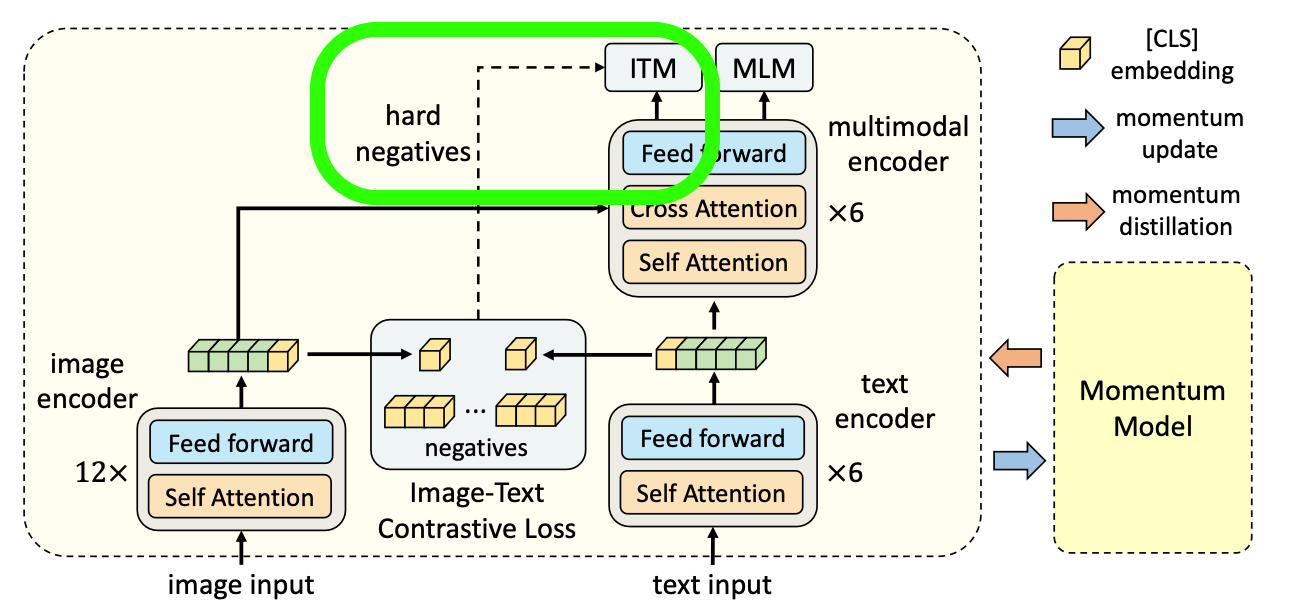

ITC 학습 과정에서 image-text similarity를 계산하는데, hard negative sample은 이를 활용해 추출함. 예를 들어, 하나의 image sample에 대한 negative text sample을 고를 때, 원래 positive pair에 해당하는 text를 제외하고 mini-batch내 나머지 text들 중 similarity확률을 multinomial disturibution이라고 보고 그중 disturibution에 따라 뽑음.  
이렇게 하면 mini-batch가 높은 similarity를 갖는 sample을 hard negative sample로 선택하는 경향을 보이게 됨

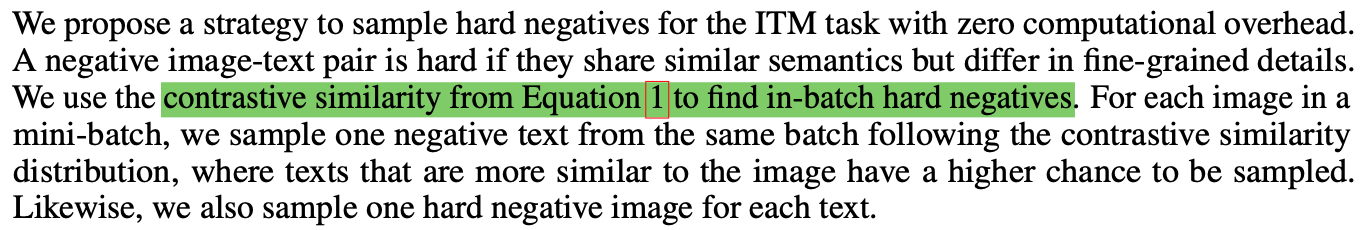

In [21]:
###=================================###
# forward the positve image-text pair
with torch.no_grad():
    bs = image_input.size(0)
    print("bs:", bs)
    weights_i2t = F.softmax(sim_i2t[:,:bs],dim=1)
    print("weights_i2t:")
    print(weights_i2t)
    weights_t2i = F.softmax(sim_t2i[:,:bs],dim=1)
    print("weights_t2i:")
    print(weights_t2i)


    weights_i2t.fill_diagonal_(0)
    weights_t2i.fill_diagonal_(0)
print("weights_t2i:")
print(weights_t2i)

# select a negative image for each text
image_embeds_neg = []    
for b in range(bs):
    neg_idx = torch.multinomial(weights_t2i[b], 1).item()
    print("neg_idx_t2i", neg_idx)
    image_embeds_neg.append(image_embeds[neg_idx])
    print("image_embeds[neg_idx]", image_embeds[neg_idx].shape)
image_embeds_neg = torch.stack(image_embeds_neg,dim=0)   
print("image_embeds_neg", image_embeds_neg.shape)

# select a negative text for each image

print("weights_i2t:")
print(weights_i2t)
text_embeds_neg = []
text_atts_neg = []
for b in range(bs):
    neg_idx = torch.multinomial(weights_i2t[b], 1).item()
    print("neg_idx_i2t", neg_idx)
    text_embeds_neg.append(text_embeds[neg_idx])
    text_atts_neg.append(text.attention_mask[neg_idx])
text_embeds_neg = torch.stack(text_embeds_neg,dim=0)   
text_atts_neg = torch.stack(text_atts_neg,dim=0)      
print("text_embeds", text_embeds.shape)
print("text_embeds_neg", text_embeds_neg.shape)

text_embeds_all = torch.cat([text_embeds, text_embeds_neg],dim=0)     
text_atts_all = torch.cat([text.attention_mask, text_atts_neg],dim=0)
print("text_embeds_all", text_embeds_all.shape)    
image_embeds_all = torch.cat([image_embeds_neg,image_embeds],dim=0)
image_atts_all = torch.cat([image_atts,image_atts],dim=0)


output_neg = text_encoder.bert(encoder_embeds = text_embeds_all, 
                                attention_mask = text_atts_all,
                                encoder_hidden_states = image_embeds_all,
                                encoder_attention_mask = image_atts_all,      
                                return_dict = True,
                                mode = 'fusion',
                                )     

output_pos = text_encoder.bert(encoder_embeds = text_embeds, 
                                attention_mask = text.attention_mask,
                                encoder_hidden_states = image_embeds,
                                encoder_attention_mask = image_atts,      
                                return_dict = True,
                                mode = 'fusion',
                                )       

itm_head = nn.Linear(text_width, 2)
vl_embeddings = torch.cat([output_pos.last_hidden_state[:,0,:], output_neg.last_hidden_state[:,0,:]],dim=0)
vl_output = itm_head(vl_embeddings)            

itm_labels = torch.cat([torch.ones(bs,dtype=torch.long),torch.zeros(2*bs,dtype=torch.long)],
                        dim=0).to(image.device)
print("vl_output", vl_output)
print("itm_labels", itm_labels)
loss_itm = F.cross_entropy(vl_output, itm_labels)     

bs: 3
weights_i2t:
tensor([[0.2925, 0.3006, 0.4069],
        [0.2944, 0.2967, 0.4089],
        [0.2959, 0.3190, 0.3851]])
weights_t2i:
tensor([[0.3452, 0.3142, 0.3407],
        [0.3464, 0.3085, 0.3451],
        [0.3524, 0.3240, 0.3236]])
weights_t2i:
tensor([[0.0000, 0.3142, 0.3407],
        [0.3464, 0.0000, 0.3451],
        [0.3524, 0.3240, 0.0000]])
neg_idx_t2i 2
image_embeds[neg_idx] torch.Size([257, 768])
neg_idx_t2i 2
image_embeds[neg_idx] torch.Size([257, 768])
neg_idx_t2i 0
image_embeds[neg_idx] torch.Size([257, 768])
image_embeds_neg torch.Size([3, 257, 768])
weights_i2t:
tensor([[0.0000, 0.3006, 0.4069],
        [0.2944, 0.0000, 0.4089],
        [0.2959, 0.3190, 0.0000]])
neg_idx_i2t 1
neg_idx_i2t 0
neg_idx_i2t 0
text_embeds torch.Size([3, 13, 768])
text_embeds_neg torch.Size([3, 13, 768])
text_embeds_all torch.Size([6, 13, 768])
vl_output tensor([[-0.7852, -0.0956],
        [-0.5558, -0.3233],
        [-0.6973, -0.2375],
        [-0.8088,  0.0344],
        [-0.5910, -0.2666],

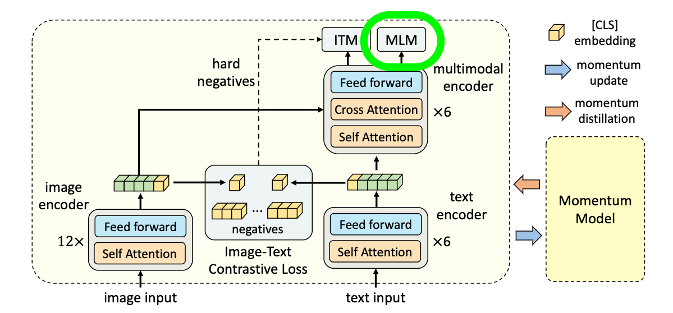

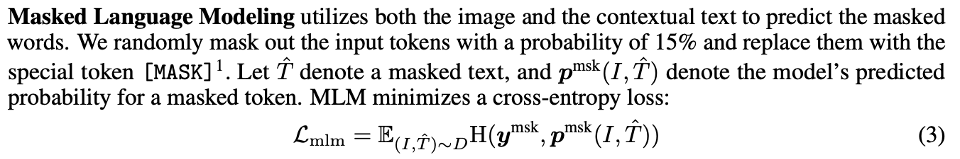

In [22]:
def mask(input_ids, vocab_size, device, targets=None, masked_indices=None, probability_matrix=None):
    if masked_indices is None:                                       
        masked_indices = torch.bernoulli(probability_matrix).bool()
                                            
    masked_indices[input_ids == tokenizer.pad_token_id] = False
    masked_indices[input_ids == tokenizer.cls_token_id] = False
    
    if targets is not None:
        targets[~masked_indices] = -100 # We only compute loss on masked tokens            

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(input_ids.shape, 0.8)).bool() & masked_indices
    input_ids[indices_replaced] = tokenizer.mask_token_id

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(input_ids.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(vocab_size, input_ids.shape, dtype=torch.long).to(device)
    input_ids[indices_random] = random_words[indices_random]                     
    # The rest of the time (10% of the time) we keep the masked input tokens unchanged   
    
    if targets is not None:
        return input_ids, targets
    else:
        return input_ids

[MASK]된 부분의 단어를 예측 전체 단어의 15%를 선택한 후 그중 80%는 [MASK], 10%는 현재 단어 유지, 10%는 임의의 단어로 대체.

In [23]:
##================= MLM ========================##                
input_ids = text.input_ids.clone()
labels = input_ids.clone()
mlm_probability = 0.15

probability_matrix = torch.full(labels.shape, mlm_probability)                    
input_ids, labels = mask(input_ids, text_encoder.config.vocab_size, image.device, targets=labels,
                                probability_matrix = probability_matrix) 

with torch.no_grad():
    logits_m = text_encoder_m(input_ids, 
                                    attention_mask = text.attention_mask,
                                    encoder_hidden_states = image_embeds_m,
                                    encoder_attention_mask = image_atts,      
                                    return_dict = True,
                                    return_logits = True,   
                                    )    
mlm_output = text_encoder(input_ids, 
                                attention_mask = text.attention_mask,
                                encoder_hidden_states = image_embeds,
                                encoder_attention_mask = image_atts,      
                                return_dict = True,
                                labels = labels,   
                                soft_labels = F.softmax(logits_m,dim=-1),
                                alpha = alpha
                                )                           
loss_mlm = mlm_output.loss


print("loss_itm", loss_itm)
print("loss_ita", loss_ita)
print("loss_mlm", loss_mlm)

loss_total = loss_itm + loss_ita + loss_mlm
print("loss_total =", loss_total)

loss_itm tensor(0.8395, grad_fn=<NllLossBackward0>)
loss_ita tensor(10.9908, grad_fn=<DivBackward0>)
loss_mlm tensor(11.5747, grad_fn=<AddBackward0>)
loss_total = tensor(23.4050, grad_fn=<AddBackward0>)


ref: https://github.com/salesforce/ALBEF